# MIE1624 Final Exam Project

## 1. Data Cleaning

In [1]:
# Import libraries.
import numpy as np
import pandas as pd
import matplotlib .pyplot as plt
import seaborn as sns
import re
import time
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

import nltk
from nltk import punkt
from nltk import RegexpTokenizer 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer, word_tokenize

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import TensorBoard

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the datasets.
senti_df = pd.read_csv('sentiment_analysis.csv', low_memory = False)
elect_df = pd.read_csv('Canadian_elections_2021.csv', low_memory = False)

In [3]:
# Remove emojis.
def remove_emoji(tweet):
    return re.sub(r'(\\x(.){2})', '', tweet)
elect_df['text'] = elect_df['text'].apply(remove_emoji)

# Remove URLs.
def remove_urls(tweet):
    return re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet)
elect_df['text'] = elect_df['text'].apply(remove_urls)

# Convert to lowercase.
def lowercase(tweet):
    return tweet.lower()
elect_df['text'] = elect_df['text'].apply(lowercase)

# Remove punctuations.
def remove_punc(tweet):
    return re.sub(r'[^\w\s]', '', tweet)
elect_df['text'] = elect_df['text'].apply(remove_punc)

# Remove stop words.
def remove_stop(tweet):
    tokenizer = RegexpTokenizer(r'\w+')
    return [word for word in tokenizer.tokenize(tweet) if word not in stopwords.words('english')]
elect_df['text'] = elect_df['text'].apply(remove_stop)

# Convert the response values, 'negative' and 'positive', to 0 and 1
elect_df['sentiment'] = elect_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
elect_df

,text,sentiment,negative_reason
0,"[canadian, election, power, grab, pm, trudeau,...",0,calling election early
1,"[hope, trudeau, loses, canadian, election, tom...",0,covid
2,"[dear, canadians, election, test, progressive,...",1,NaN
3,"[canadian, friends, never, forget, trudeau, 2,...",0,calling election early
4,"[sorry, thejagmeetsingh, voted, ndp, life, ele...",1,NaN
...,...,...,...
997,"[absolutely, horrible, canada, forthcoming, el...",0,others
998,"[davidakin, trudeau, imposes, gun, control, po...",0,gun control
999,"[canada, election, stolen, thugs, uneducated, ...",0,others
1000,"[otoole, amends, platform, gun, control, quest...",0,tell lies


In [4]:
%%time
# Remove emojis.
senti_df['text'] = senti_df['text'].apply(remove_emoji)

# Remove URLs.
senti_df['text'] = senti_df['text'].apply(remove_urls)

# Convert to lowercase.
senti_df['text'] = senti_df['text'].apply(lowercase)

# Remove punctuations.
senti_df['text'] = senti_df['text'].apply(remove_punc)

# Remove stop words.
def remove_stop_1(tweet):
    tokenizer = RegexpTokenizer(r'\w+')
    return ' '.join([word for word in tokenizer.tokenize(tweet) if word not in stopwords.words('english')])
senti_df['text'] = senti_df['text'].apply(remove_stop_1)
senti_df

CPU times: user 11min 28s, sys: 2min 23s, total: 13min 52s
Wall time: 14min 57s


,ID,text,label
0,7.680980e+17,josh jenkins looking forward tab breeders crow...,1
1,7.680980e+17,rt mianusmanjaved congratulations pakistan bec...,1
2,7.680980e+17,rt pepalerts september yesmag taking maine men...,1
3,7.680980e+17,rt david_gaibis newly painted walls thanks mil...,1
4,7.680980e+17,rt cedricfeschotte excited announce july 2017 ...,1
...,...,...,...
550386,8.046170e+17,goddesses_o cant stop watching hermm,0
550387,8.046180e+17,poor old tom odell doesnt look like would know...,0
550388,8.046180e+17,antsmasher smashed 7 ants awesome gamehjfjfi,1
550389,8.046180e+17,lizhudston kymwyllie evasmiless meanbok linddy...,1


## 2. Exploratory analysis

Define a function that classifies the party each tweet supports.

In [5]:
def classify_party(tweet):
    classify_list = []

    liberal = ['lpc', 'justin', 'justintrudeau', 'voteliberal', 'liberal', 'teamtrudeau', 'trudeau', 'justin']
    conservative = ['conservatives', 'cpc', 'cpc_hq', 'votecpc', 'conservative']
    ndp = ['ndp', 'jagmeet', 'thejagmeetsingh', "orange", "quebec", 'singh']
    ppc = ['ppc']
    
    # Classify the party by the keywords of each list.
    for word in tweet:
        if word in liberal:
            classify_list.append('Liberal')
        if word in conservative:
            classify_list.append('Conservatives')
        if word in ndp:
            classify_list.append('New Democratic Party')
        if word in ppc:
            classify_list.append("The People's Party of Canada")
    
    # Return the party that appear most times if multiple parties appear in the single tweet.
    if len(classify_list) > 1:
        most_frequent = max(set(classify_list), key = classify_list.count)
        classify_list = []
        classify_list.append(most_frequent)
    
    # If there is no party mentioned in the tweet, return None.
    elif len(classify_list) == 0:
        classify_list.append('None')
    
    return classify_list[0]

In [6]:
# Determine the party associated with the tweet.
elect_df['Party'] = list(map(classify_party, elect_df['text']))

# If Justin Trudeau's name is mentioned, and the sentiment is negative, and the reason is "tell lies",
# classify it as 'None' since it is a bad comment on the current leader.
elect_df['Party'] = np.where(elect_df['negative_reason'] == 'tell lies', 'None', elect_df['Party'])
elect_df['Party']

0                    Liberal
1                    Liberal
2                       None
3                    Liberal
4       New Democratic Party
                ...         
997                     None
998                  Liberal
999                     None
1000                    None
1001                    None
Name: Party, Length: 1002, dtype: object

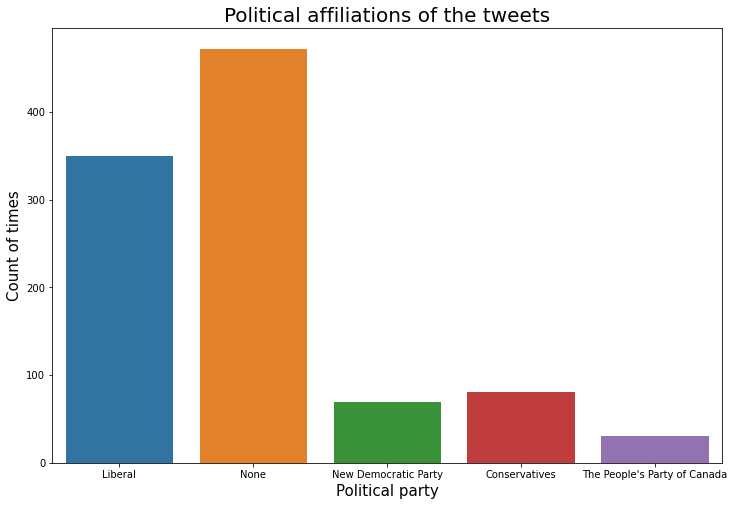

In [7]:
# Histogram of political parties. (including None)
plt.figure(figsize=(12, 8))
ax = sns.countplot(x = 'Party', data = elect_df)
ax.axes.set_title('Political affiliations of the tweets', fontsize = 20)
ax.set_xlabel('Political party', fontsize = 15)
ax.set_ylabel('Count of times', fontsize = 15)
plt.show()

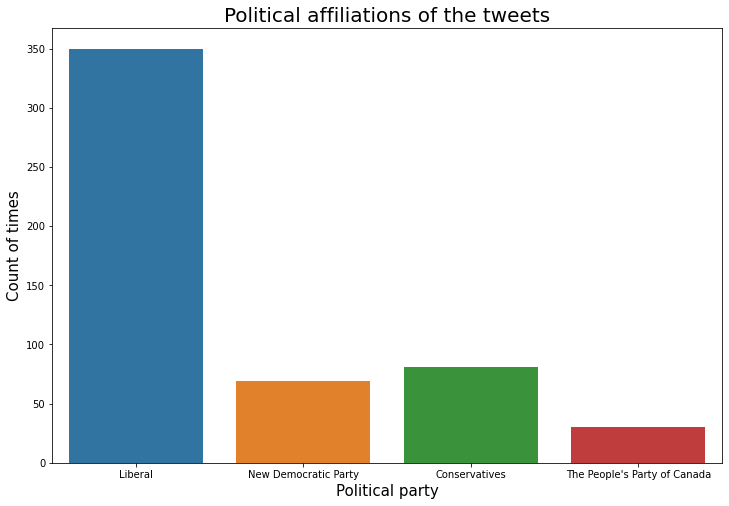

In [8]:
# Histogram of political parties. (exclude None)
plt.figure(figsize=(12, 8))
ax = sns.countplot(x = 'Party', data = elect_df[elect_df['Party'] != 'None'])
ax.axes.set_title('Political affiliations of the tweets', fontsize = 20)
ax.set_xlabel('Political party', fontsize = 15)
ax.set_ylabel('Count of times', fontsize = 15)
plt.show()

### 2021 Election Results

Liberal party: 160
Conservative party: 119
New Democratic party: 25
The People's Party of Canada: 0

Text(0.5, 1.0, 'Seat Distribution of 2021 Canadian federal election')

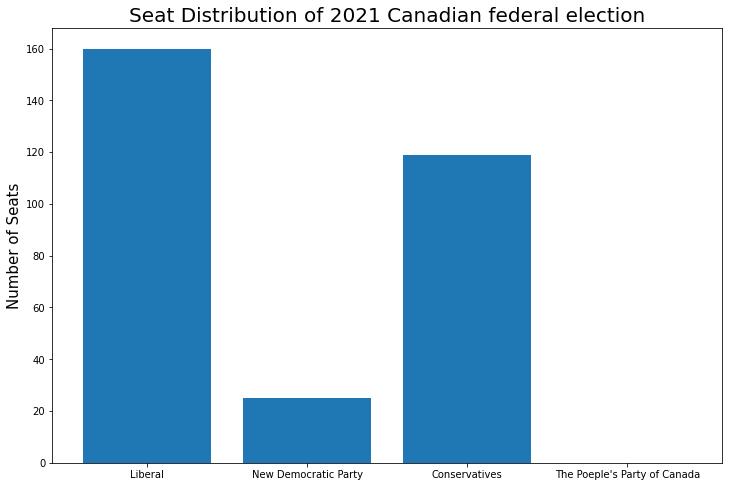

In [9]:
# Visualize the seat distribution of 2021 Canadian federal election, to compare with the classification results.
x_tick = ['Liberal', 'New Democratic Party', 'Conservatives', "The Poeple's Party of Canada"]
seats = [160, 25, 119, 0]
plt.figure(figsize=(12, 8))
plt.bar(x_tick, seats)
plt.ylabel('Number of Seats', fontsize = 15)
plt.title('Seat Distribution of 2021 Canadian federal election', fontsize = 20)

We can see from the two plots that among four parties, Liberal is the most popular party to mention on Twitter, and they have gained the highest number of seats in 2021 election. Compared with the plot of political affiliations of the tweets, conservatives gained more popularities in the seat distribution plot, they are also the second most popular party on Twitter. Followed by New Democratic Party, they earned a fair amount of seats in 2021 election. Lastly, The People's Party of Canada gained no seat in 2021 election, and is the least popular party mentioned on Twitter, considering it is relatively small on size, and relatively new in history, the result is not suprising.

#### Create a wordcloud for sentiment_analysis dataset.

CPU times: user 34.1 s, sys: 2.32 s, total: 36.4 s
Wall time: 39.3 s


(-0.5, 1999.5, 999.5, -0.5)

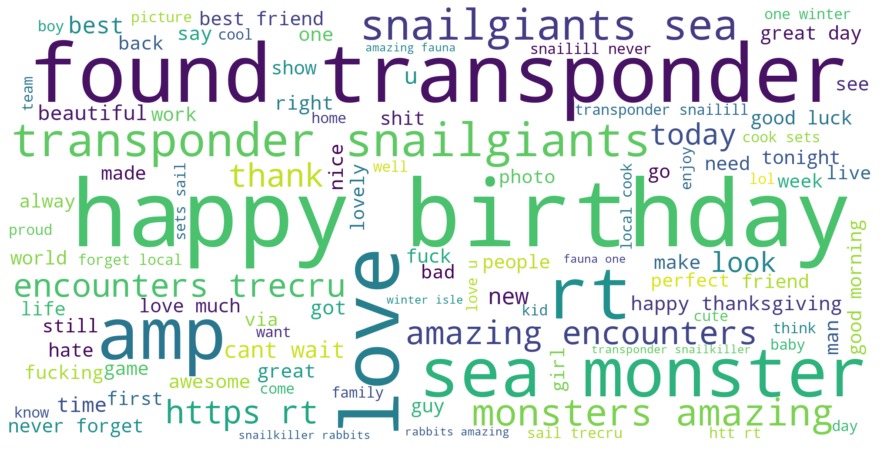

In [10]:
%%time
words_list = []
templist = []
for i in range(len(senti_df['text'])):
    templist = senti_df['text'][i].split()
    for word in templist:
        words_list.append(word)

words_list = ' '.join(words_list)
wordcloud1 = WordCloud(background_color='white',
                       max_words=100,
                       width=2000,
                       height=1000).generate(words_list)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')

## 3. Sentiment Classification - Model implementation and tuning

### a) Machine learning models.

#### Split the generic tweets randomly into training data (80%) and test data (20%).

In [11]:
senti_X = senti_df['text']
senti_y = senti_df['label']

senti_X_train, senti_X_test, senti_y_train, senti_y_test = train_test_split(senti_X, senti_y, test_size=0.2, random_state = 1624)

#### Prepare the data using TF-IDF.

In [12]:
# Transform generic tweets and set max_features to be 1000
tf_idf_Vectorizer = TfidfVectorizer(max_features=1000)

tf_idf_train = tf_idf_Vectorizer.fit_transform(senti_X_train)
tf_idf_test = tf_idf_Vectorizer.transform(senti_X_test)

#### Train seven classification algorithms & Evaluate each model on the test data.

##### Logistic regression

In [13]:
%%time
lr_model = LogisticRegression()
lr_model.fit(tf_idf_train, senti_y_train)

print(round(accuracy_score(senti_y_test, lr_model.predict(tf_idf_test)), 4))
print(classification_report(senti_y_test, lr_model.predict(tf_idf_test)))

0.9406
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     35821
           1       0.96      0.95      0.96     74258

    accuracy                           0.94    110079
   macro avg       0.93      0.94      0.93    110079
weighted avg       0.94      0.94      0.94    110079

CPU times: user 3.59 s, sys: 140 ms, total: 3.73 s
Wall time: 3.97 s


##### k-NN model

In [14]:
%%time
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(tf_idf_train, senti_y_train)

print(round(accuracy_score(senti_y_test, knn_model.predict(tf_idf_test)), 4))
print(classification_report(senti_y_test, knn_model.predict(tf_idf_test)))

0.876
              precision    recall  f1-score   support

           0       0.77      0.88      0.82     35821
           1       0.94      0.87      0.90     74258

    accuracy                           0.88    110079
   macro avg       0.85      0.88      0.86    110079
weighted avg       0.88      0.88      0.88    110079

CPU times: user 28min 35s, sys: 7min 22s, total: 35min 58s
Wall time: 37min 27s


##### Naive Bayes

In [16]:
%%time
nb_model = GaussianNB()
nb_model.fit(tf_idf_train.toarray(), senti_y_train)

print(round(accuracy_score(senti_y_test, nb_model.predict(tf_idf_test.toarray())), 4))

0.8594
CPU times: user 11.5 s, sys: 17.8 s, total: 29.3 s
Wall time: 39.4 s


##### Support Vector Machine

In [17]:
%%time
SVM_model = LinearSVC()
SVM_model.fit(tf_idf_train, senti_y_train)

print(round(accuracy_score(senti_y_test, SVM_model.predict(tf_idf_test)), 4))

0.9405
CPU times: user 2.69 s, sys: 90.6 ms, total: 2.78 s
Wall time: 2.87 s


##### Decision trees

In [18]:
%%time
dt_model = DecisionTreeClassifier()
dt_model.fit(tf_idf_train, senti_y_train)

print(round(accuracy_score(senti_y_test, dt_model.predict(tf_idf_test)), 4))

0.9285
CPU times: user 1min 36s, sys: 733 ms, total: 1min 37s
Wall time: 1min 43s


##### Random Forest

In [19]:
%%time
rf_model = RandomForestClassifier()
rf_model.fit(tf_idf_train, senti_y_train)

print(round(accuracy_score(senti_y_test, rf_model.predict(tf_idf_test)), 4))

0.9441
              precision    recall  f1-score   support

           0       0.90      0.93      0.92     35821
           1       0.97      0.95      0.96     74258

    accuracy                           0.94    110079
   macro avg       0.93      0.94      0.94    110079
weighted avg       0.94      0.94      0.94    110079

CPU times: user 15min 51s, sys: 7.13 s, total: 15min 59s
Wall time: 16min 35s


##### XGBoost

In [20]:
%%time
XGBoost_model = GradientBoostingClassifier()
XGBoost_model.fit(tf_idf_train, senti_y_train)

print(round(accuracy_score(senti_y_test, XGBoost_model.predict(tf_idf_test)), 4))

0.8033
CPU times: user 1min 35s, sys: 2.75 s, total: 1min 38s
Wall time: 1min 45s


| Model | Accuracy |
| ------------- | ------------- |
| **Logistic Regression** | **0.9406** |
| **k-NN** | 0.8760 |
| **Naive Bayes** | 0.8594 |
| **SVM** | 0.9405 |
| **Decision Tree** | 0.9284 |
| **Random Forest Tree** | 0.9441 |
| **XGBoost** | 0.8033 |

### b) Deep learning model:

#### Split the generic tweets randomly into training data (60%), validation data (20%) and test data (20%).

In [21]:
senti_X_train_wf_full, senti_X_test_wf, senti_y_train_wf_full, senti_y_test_wf = train_test_split(senti_X, senti_y, test_size=0.2, random_state = 1)
senti_X_train_wf, senti_X_val_wf, senti_y_train_wf, senti_y_val_wf = train_test_split(senti_X_train_wf_full, senti_y_train_wf_full, test_size=0.25, random_state = 0)


#### Prepare the data using WF.

In [22]:
# Transform generic tweets and set max_features to be 1000 (sacrifice max_features to reduce long running time).
wf_Vectorizer = CountVectorizer(max_features=1000)

wf_train = wf_Vectorizer.fit_transform(senti_X_train_wf)
wf_val = wf_Vectorizer.fit_transform(senti_X_val_wf)
wf_test = wf_Vectorizer.transform(senti_X_test_wf)

#wf_train = tf.keras.utils.normalize(wf_train, axis=1)
#wf_val = tf.keras.utils.normalize(wf_val, axis=1)

In [23]:
wf_train = pd.DataFrame.sparse.from_spmatrix(data = wf_train)
wf_val = pd.DataFrame.sparse.from_spmatrix(data = wf_val)
wf_test = pd.DataFrame.sparse.from_spmatrix(data = wf_test)

##### I tried to tune the hyperparameters using grid search but the running time is significantly high, so I decided to tune manually. The hyperparameters I am using are batch_size and nodes per layer.

##### batch_size = 32, nodes per layer = 1

In [24]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu)) # 1st node
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(wf_train, senti_y_train_wf, batch_size=32, epochs=5)

val_loss, val_acc = model.evaluate(wf_val, senti_y_val_wf)
val_acc

2022-04-20 22:37:23.756730: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
10320/10320 [==============================] - 24s 2ms/step - loss: 0.1718 - accuracy: 0.9341
Epoch 2/5
10320/10320 [==============================] - 21s 2ms/step - loss: 0.1402 - accuracy: 0.9446
Epoch 3/5
10320/10320 [==============================] - 22s 2ms/step - loss: 0.1297 - accuracy: 0.9493
Epoch 4/5
10320/10320 [==============================] - 20s 2ms/step - loss: 0.1213 - accuracy: 0.9533
Epoch 5/5
3440/3440 [==============================] - 4s 1ms/step - loss: 1.7812 - accuracy: 0.6011


0.6011101007461548

##### batch_size = 32, nodes per layer = 2

In [25]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu)) # 1st node
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu)) # 2nd node
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(wf_train, senti_y_train_wf, batch_size=32, epochs=5)

val_loss, val_acc = model.evaluate(wf_val, senti_y_val_wf)
val_acc

Epoch 1/5
10320/10320 [==============================] - 19s 2ms/step - loss: 0.1653 - accuracy: 0.9347
Epoch 2/5
10320/10320 [==============================] - 20s 2ms/step - loss: 0.1383 - accuracy: 0.9457
Epoch 3/5
10320/10320 [==============================] - 19s 2ms/step - loss: 0.1248 - accuracy: 0.9514
Epoch 4/5
10320/10320 [==============================] - 19s 2ms/step - loss: 0.1133 - accuracy: 0.9564
Epoch 5/5
3440/3440 [==============================] - 4s 1ms/step - loss: 1.7115 - accuracy: 0.5722


0.5721669793128967

##### batch_size = 32, nodes per layer = 3.

In [26]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu)) # 1st node
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu)) # 2nd node
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu)) # 3rd node
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(wf_train, senti_y_train_wf, batch_size=32, epochs=5)

val_loss, val_acc = model.evaluate(wf_val, senti_y_val_wf)
val_acc

Epoch 1/5
10320/10320 [==============================] - 20s 2ms/step - loss: 0.1632 - accuracy: 0.9356
Epoch 2/5
10320/10320 [==============================] - 19s 2ms/step - loss: 0.1360 - accuracy: 0.9465
Epoch 3/5
10320/10320 [==============================] - 19s 2ms/step - loss: 0.1221 - accuracy: 0.9526
Epoch 4/5
10320/10320 [==============================] - 19s 2ms/step - loss: 0.1098 - accuracy: 0.9579
Epoch 5/5
3440/3440 [==============================] - 4s 1ms/step - loss: 1.6687 - accuracy: 0.5978


0.5977579355239868

##### batch_size = 64, nodes per layer = 1.

In [27]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu)) # 1st node
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(wf_train, senti_y_train_wf, batch_size=64, epochs=5)

val_loss, val_acc = model.evaluate(wf_val, senti_y_val_wf)
val_acc

Epoch 1/5
5160/5160 [==============================] - 11s 2ms/step - loss: 0.1825 - accuracy: 0.9322
Epoch 2/5
5160/5160 [==============================] - 12s 2ms/step - loss: 0.1414 - accuracy: 0.9440
Epoch 3/5
5160/5160 [==============================] - 13s 3ms/step - loss: 0.1300 - accuracy: 0.9486
Epoch 4/5
5160/5160 [==============================] - 11s 2ms/step - loss: 0.1212 - accuracy: 0.9527
Epoch 5/5
3440/3440 [==============================] - 5s 2ms/step - loss: 1.5412 - accuracy: 0.6089


0.6088591814041138

##### batch_size = 64, nodes per layer = 2.

In [28]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu)) # 1st node
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu)) # 2nd node
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(wf_train, senti_y_train_wf, batch_size=64, epochs=5)

val_loss, val_acc = model.evaluate(wf_val, senti_y_val_wf)
val_acc

Epoch 1/5
5160/5160 [==============================] - 11s 2ms/step - loss: 0.1711 - accuracy: 0.9334
Epoch 2/5
5160/5160 [==============================] - 10s 2ms/step - loss: 0.1405 - accuracy: 0.9446
Epoch 3/5
5160/5160 [==============================] - 14s 3ms/step - loss: 0.1284 - accuracy: 0.9496
Epoch 4/5
5160/5160 [==============================] - 13s 3ms/step - loss: 0.1162 - accuracy: 0.9547
Epoch 5/5
3440/3440 [==============================] - 5s 1ms/step - loss: 1.6730 - accuracy: 0.6009


0.6009193658828735

##### batch_size = 64, nodes per layer = 3.

In [29]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu)) # 1st node
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu)) # 2nd node
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu)) # 3rd node
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(wf_train, senti_y_train_wf, batch_size=64, epochs=5)

val_loss, val_acc = model.evaluate(wf_val, senti_y_val_wf)
val_acc

Epoch 1/5
5160/5160 [==============================] - 18s 3ms/step - loss: 0.1678 - accuracy: 0.9341
Epoch 2/5
5160/5160 [==============================] - 13s 3ms/step - loss: 0.1367 - accuracy: 0.9462
Epoch 3/5
5160/5160 [==============================] - 15s 3ms/step - loss: 0.1208 - accuracy: 0.9526
Epoch 4/5
5160/5160 [==============================] - 14s 3ms/step - loss: 0.1064 - accuracy: 0.9582
Epoch 5/5
3440/3440 [==============================] - 5s 2ms/step - loss: 2.0850 - accuracy: 0.5925


0.5925162434577942

##### Based on the model tuning, the best model is when batch_size is 32, nodes per layer is 2.

In [30]:
best_model = tf.keras.models.Sequential()
best_model.add(tf.keras.layers.Flatten())
best_model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu)) # 1st node
best_model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu)) # 2nd node
best_model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

best_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

best_model.fit(wf_train, senti_y_train_wf, batch_size=32, epochs=5)

test_loss, test_acc = best_model.evaluate(wf_test, senti_y_test_wf)
test_acc

Epoch 1/5
10320/10320 [==============================] - 25s 2ms/step - loss: 0.1652 - accuracy: 0.9346
Epoch 2/5
10320/10320 [==============================] - 22s 2ms/step - loss: 0.1381 - accuracy: 0.9460
Epoch 3/5
10320/10320 [==============================] - 22s 2ms/step - loss: 0.1248 - accuracy: 0.9515
Epoch 4/5
10320/10320 [==============================] - 21s 2ms/step - loss: 0.1129 - accuracy: 0.9562
Epoch 5/5
3440/3440 [==============================] - 4s 1ms/step - loss: 1.5864 - accuracy: 0.5990


0.5989607572555542

##### The accuracy score on the test dataset evaluated on the best model is 0.5990.

### c) Evaluate the trained model with the best performance (considering all models from part a) and part b)) on the Canadian Elections data.

The best model among machine learning models and deep learning models is Logistic Regression, with a accuracy of 0.9406.

In [31]:
# I re-did the data cleaning to change the output type of 'text' from list to string. Everything else is the same.

elect_df_1 = pd.read_csv('Canadian_elections_2021.csv', low_memory = False)

# Remove emojis.
elect_df_1['text'] = elect_df_1['text'].apply(remove_emoji)

# Remove URLs.
elect_df_1['text'] = elect_df_1['text'].apply(remove_urls)

# Convert to lowercase.
elect_df_1['text'] = elect_df_1['text'].apply(lowercase)

# Remove punctuations.
elect_df_1['text'] = elect_df_1['text'].apply(remove_punc)

# Remove stop words.
elect_df_1['text'] = elect_df_1['text'].apply(remove_stop_1)

# Convert the response values, 'negative' and 'positive', to 0 and 1
elect_df_1['sentiment'] = elect_df_1['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
elect_df_1

,text,sentiment,negative_reason
0,canadian election power grab pm trudeau yes ta...,0,calling election early
1,hope trudeau loses canadian election tomorrow ...,0,covid
2,dear canadians election test progressive wheth...,1,NaN
3,canadian friends never forget trudeau 2 years ...,0,calling election early
4,sorry thejagmeetsingh voted ndp life election ...,1,NaN
...,...,...,...
997,absolutely horrible canada forthcoming electio...,0,others
998,davidakin trudeau imposes gun control policies...,0,gun control
999,canada election stolen thugs uneducated goons ...,0,others
1000,otoole amends platform gun control questions r...,0,tell lies


In [32]:
elect_X = elect_df_1['text']
elect_y = elect_df_1['sentiment']

tf_idf_elect = tf_idf_Vectorizer.transform(elect_X)

In [33]:
print(round(accuracy_score(elect_y, lr_model.predict(tf_idf_elect)), 4))

0.6956


The accuracy score dropped significantly from 0.9406 to 0.6956, considering the datasets do not come from the same distribution, I personally think that Logistic model performed well.

### d). Propose two other evaluation metrics you could use to evaluate the models.

In [34]:
print(classification_report(senti_y_test, lr_model.predict(tf_idf_test)))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     35821
           1       0.96      0.95      0.96     74258

    accuracy                           0.94    110079
   macro avg       0.93      0.94      0.93    110079
weighted avg       0.94      0.94      0.94    110079



Precision, recall are other good metrics that we could use for evaluating models. Recall is the true positive rate, it shows how many "positive" observations are classified correctly; while precision is the rate of actual "positive" over all observations classified as "positive".

We can get a sense of not only how many observations are correctly classified, but also how many "positive" observations are classified correctly, and how many should be classified as "positive" but were not. We can assess on whether our model might be overfitting or not based on these two metrics.

### e.

In [35]:
# Create a dataframe containing model predictions for each observation (that has an affiliated party).

result_df = elect_df[['sentiment']]
result_df['prediction'] = lr_model.predict(tf_idf_elect)
result_df['Party'] = elect_df.loc[result_df.index, 'Party']
result_df = result_df.loc[result_df['Party'] != 'None']
result_df

,sentiment,prediction,Party
0,0,1,Liberal
1,0,1,Liberal
3,0,0,Liberal
4,1,0,New Democratic Party
9,1,0,Liberal
...,...,...,...
985,0,0,New Democratic Party
986,0,0,Liberal
991,0,0,Liberal
992,0,0,Liberal


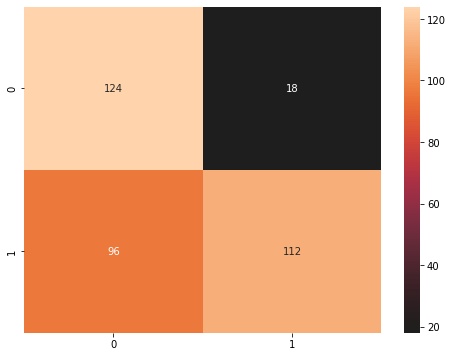

In [36]:
# Extract observations for Liberal party from dataframe result_df, to form a new dataframe.
Liberal_df = result_df[result_df['Party']=='Liberal']

# Create a confusion matrix to see how did the model perform on Liberal party-affiliated tweets.
cm_liberal = confusion_matrix(Liberal_df['sentiment'], Liberal_df['prediction'])

# Plot the confusion matrix for Liberal party.
plt.figure(figsize=(8, 6))
sns.heatmap(cm_liberal, annot=True, fmt='d', center=18)
plt.savefig('cm_liberal')

In [37]:
print(classification_report(Liberal_df['sentiment'], Liberal_df['prediction']))

              precision    recall  f1-score   support

           0       0.56      0.87      0.69       142
           1       0.86      0.54      0.66       208

    accuracy                           0.67       350
   macro avg       0.71      0.71      0.67       350
weighted avg       0.74      0.67      0.67       350



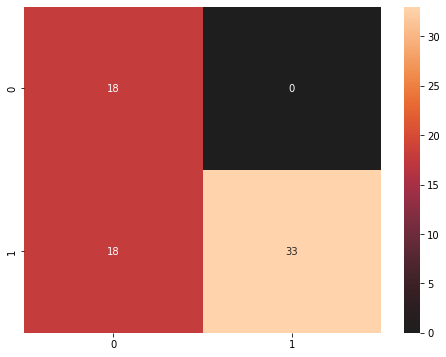

In [38]:
# Extract observations for New Democratic Party from dataframe result_df, to form a new dataframe.
ndp_df = result_df[result_df['Party']=='New Democratic Party']

# Create a confusion matrix to see how did the model perform on Liberal party-affiliated tweets.
cm_ndp = confusion_matrix(ndp_df['sentiment'], ndp_df['prediction'])

# Plot the confusion matrix for New Democratic Party.
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ndp, annot=True, fmt='d', center=0)
plt.savefig('cm_ndp')

In [39]:
print(classification_report(ndp_df['sentiment'], ndp_df['prediction']))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        18
           1       1.00      0.65      0.79        51

    accuracy                           0.74        69
   macro avg       0.75      0.82      0.73        69
weighted avg       0.87      0.74      0.75        69



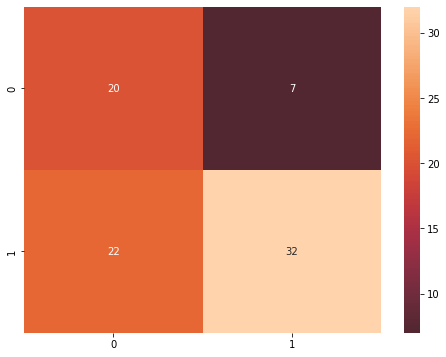

In [40]:
# Extract observations for Conservatives Party from dataframe result_df, to form a new dataframe.
conservative_df = result_df[result_df['Party']=='Conservatives']

# Create a confusion matrix to see how did the model perform on Conservatives Party-affiliated tweets.
cm_conservative = confusion_matrix(conservative_df['sentiment'], conservative_df['prediction'])

# Plot the confusion matrix for Conservatives Party.
plt.figure(figsize=(8, 6))
sns.heatmap(cm_conservative, annot=True, fmt='d', center=0)
plt.savefig('cm_conservative')

In [41]:
print(classification_report(conservative_df['sentiment'], conservative_df['prediction']))

              precision    recall  f1-score   support

           0       0.48      0.74      0.58        27
           1       0.82      0.59      0.69        54

    accuracy                           0.64        81
   macro avg       0.65      0.67      0.63        81
weighted avg       0.71      0.64      0.65        81



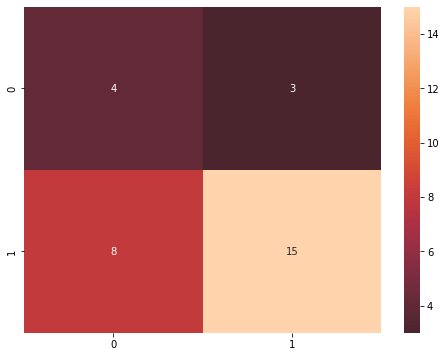

In [42]:
# Extract observations for The People's Party of Canada from dataframe result_df, to form a new dataframe.
ppc_df = result_df[result_df['Party']=="The People's Party of Canada"]

# Create a confusion matrix to see how did the model perform on Conservatives Party-affiliated tweets.
cm_ppc = confusion_matrix(ppc_df['sentiment'], ppc_df['prediction'])

# Plot the confusion matrix for Conservatives Party.
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ppc, annot=True, fmt='d', center=0)
plt.savefig('cm_ppc')

In [43]:
print(classification_report(ppc_df['sentiment'], ppc_df['prediction']))

              precision    recall  f1-score   support

           0       0.33      0.57      0.42         7
           1       0.83      0.65      0.73        23

    accuracy                           0.63        30
   macro avg       0.58      0.61      0.58        30
weighted avg       0.72      0.63      0.66        30



Overall, I think Logistic regression performed well on predicting sentiment, the f1-scores for four parties are all larger than 0.68. Given the small data size, I think the model is appropriate.

However, overall, I think NLP analytics based on tweets might not be very useful for political parties during election campaigns. There are a few issues with the model: data size, low accuracy (60% is considering low), and ambiguities (meaning that the method cannot classify good or bad review of the party mentioned in the tweet, it can always classifies to good).

From the confusion matrices, we see that expect for Liberal party, other three parties all have more positives than negatives, which suggests that the public has a bad impression for Liberal party.

One way to improve the model accuracy is to tune a few hyperparameters using grid search.

## 4. Negative Reason Classification - Model implementation and tuning

First, I will visualize the distribution of negative review reasons.

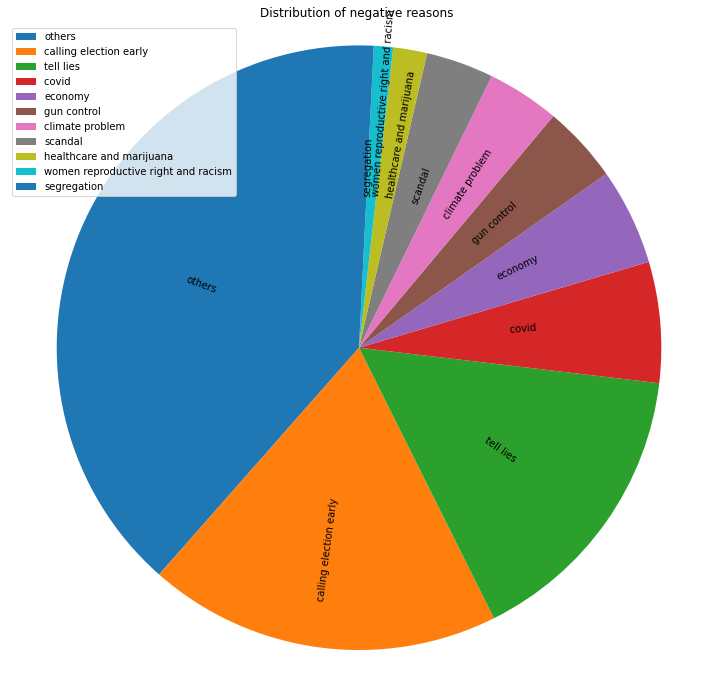

In [44]:
neg_reasons = elect_df['negative_reason'].tolist()
neg_reasons = [x for x in neg_reasons if str(x) != 'nan']
neg_count = pd.value_counts(neg_reasons)

# Create a pie chart that demonstrating the distribution of reasons for negative sentiment.
fig, ax = plt.subplots(figsize=[10, 10])
ax.pie(neg_count.values, labels=neg_count.index, rotatelabels=True,labeldistance=0.5, pctdistance=0.6, startangle=90)
ax.axis('equal')
ax.set_title('Distribution of negative reasons')
plt.legend(loc="upper left")
fig.tight_layout()
plt.show()

In [48]:
elect_df_negative = elect_df_1[elect_df_1['sentiment'] == 0]

elect_X = elect_df_negative['text']
elect_y = elect_df_negative['negative_reason']

In [49]:
elect_X_train, elect_X_test, elect_y_train, elect_y_test = train_test_split(elect_X, elect_y, test_size=0.3, random_state = 1624)

In [50]:
tf_idf_train_elect = tf_idf_Vectorizer.transform(elect_X_train)
tf_idf_test_elect = tf_idf_Vectorizer.transform(elect_X_test)

In [51]:
params = {'max_features': list(range(5, 300, 5)), 'min_samples_split': list(range(1, 30, 2))}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=10)
grid_search_cv.fit(tf_idf_train_elect, elect_y_train)

Fitting 10 folds for each of 885 candidates, totalling 8850 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_features': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50,
                                          55, 60, 65, 70, 75, 80, 85, 90, 95,
                                          100, 105, 110, 115, 120, 125, 130,
                                          135, 140, 145, 150, ...],
                         'min_samples_split': [1, 3, 5, 7, 9, 11, 13, 15, 17,
                                               19, 21, 23, 25, 27, 29]},
             verbose=1)

In [52]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_features=50, min_samples_split=17, random_state=42)

In [53]:
best_dt = DecisionTreeClassifier(max_features=50, min_samples_split=17, random_state=42)

In [54]:
best_dt.fit(tf_idf_train_elect, elect_y_train)

DecisionTreeClassifier(max_features=50, min_samples_split=17, random_state=42)

In [55]:
print(round(accuracy_score(elect_y_test, best_dt.predict(tf_idf_test_elect)), 4))

0.4359


### a).

1. There are too many features compared to its dataset size. There are only 270 observations in the training set, but the best model selected by grid search has 50 features, resulting in underfitting of our model.
2. The response has multiple levels, making it hard to distinguish when the corresponsing features are similar. For example, "calling election early" is not conflict with other negative reasons so it might have similar tweet contents with others, thus, when the model classifies the label, it might confuse these two labels (negative reasons).

### b).

One way to improve accurcy is to increase dataset size, and combine similar reasons into fewer categories, in this way some ambiguities would be eliminated.